In [173]:
using CSV, DataFrames, Statistics, Clustering, Plots, Random, Gurobi, JuMP, DataStructures, StatsBase

In [205]:
data_prev = CSV.read("data/pred_Maria.csv",DataFrame)
data_opti = CSV.read("data/opti_Maria.csv",DataFrame);

In [206]:
#number booked appointments
na = nrow(data_prev)
#number new appointments
nb = nrow(data_opti)
ntot = na + nb
#number doctors
nd = 22
#penalty added nurse
pen_nurse = 5

5

In [207]:
s = data_prev.slot .+1 ;
a = Matrix(data_opti[:,31:35]);
p = rand(ntot, 50);

In [211]:
s_m = reshape(counts(s, 50), (10,5));

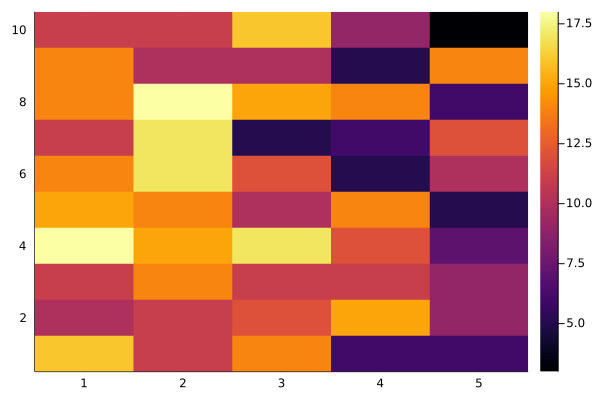

In [212]:
heatmap(s_m)

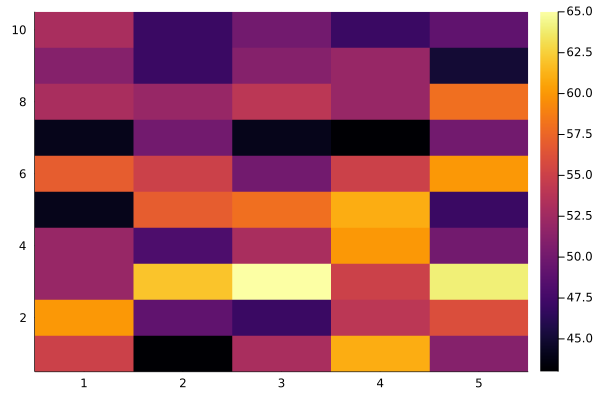

In [219]:
a_m = reshape(counts(a, 50), (10,5))
heatmap(a_m)

### Model 1 : Only penalize double booking

In [221]:
model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
set_optimizer_attribute(model, "OutputFlag", 0)

@variable(model, x[1:ntot, 1:50], Bin)
@variable(model, t[1:50])

@objective(model, Min, sum(t)*pen_nurse)

@constraint(model, [j=1:50], t[j] >= sum(x[i,j]*p[i,j] for i=1:ntot) - nd) #
@constraint(model, [j=1:50], t[j] >= 0)

for i=1:na
    for j=1:50
        if s[i]==j
            @constraint(model, x[i,j] == 1)
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

for i=na+1:ntot
    for j=1:50
        if j in a[i-na,:]
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

@constraint(model, [i=1:ntot], sum(x[i,j] for j=1:50) == 1)
        

optimize!(model);

Academic license - for non-commercial use only - expires 2022-08-18


In [222]:
x = JuMP.value.(x);

In [223]:
schedule = reshape(sum(x[i,:] for i=1:ntot), (10,5))

10×5 Matrix{Float64}:
 16.0  16.0  14.0  23.0  25.0
 18.0  11.0  16.0  15.0  44.0
 26.0  14.0  15.0  11.0   9.0
 18.0  23.0  31.0  12.0  45.0
 36.0  28.0  10.0  16.0  45.0
 26.0  17.0  36.0  12.0  11.0
 11.0  23.0  46.0  30.0  42.0
 43.0  20.0  16.0  14.0   9.0
 21.0  50.0  32.0   8.0  18.0
 12.0  13.0  16.0  12.0  42.0

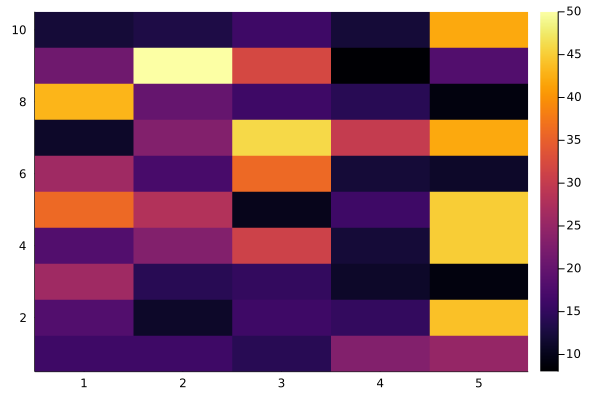

In [224]:
heatmap(schedule)

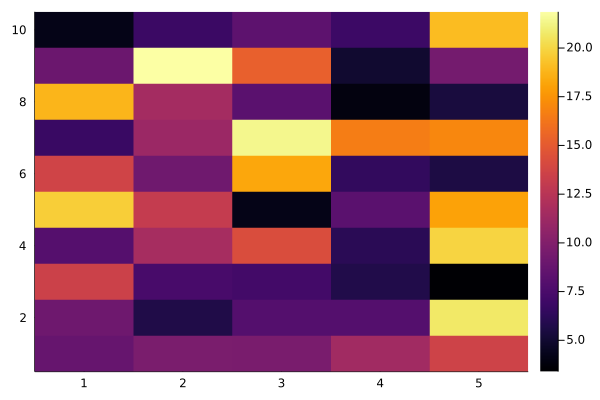

In [232]:
schedule_show = reshape([sum(x[i,j]*p[i,j] for i=1:ntot) for j=1:50], (10,5));
heatmap(schedule_show)